# Class Activation Map

### Yonsei App.Stat. 
### Sunwoo Kim

### Source paper : http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

오늘은 class activation map에 대해 확인해보도록 하겠습니다.  
Class activation map은 Global Average Pooling을 시행하는 architecture에 적용 가능하며,  
마지막 conv layer에 weight를 곱하여 HeatMap을 생성합니다.

## A. Image classification model Training

### A.1. Importing Data

데이터는 CIFAR10을 사용하고, 모델은 VGG+GAP을 사용하도록 하겠습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123)

**Transform data (Normalization)**

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**CIFAR에는 총 10개의 class가 있으므로, 그것을 그대로 반영합니다.**

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Visualization data**

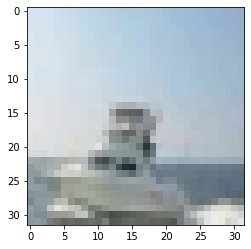

ship


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img, label = trainset[100] 
imshow(img)
print(classes[label])

배가 상당히 멋집니다! 이제 모델을 불러오겠습니다.

### A.2. Define model

Pytorch에 내장된 VGG architecture는 Image-Net 용으로 구현되어있고, FC layer에서 1000개의 output을 출력합니다. 따라서 CIFAR에 맞게 데이터를 변형하도록 하겠습니다.  
VGG 모델은https://github.com/deeplearningzerotoall/PyTorch 을 참고하였습니다.

In [6]:
class VGG(nn.Module): 
    def __init__(self, features, num_classes=10, init_weights=True) :
        super(VGG, self).__init__()
        self.features = features # Convolution layers의 구조는 그대로 활용
        self.gap = torch.nn.AdaptiveAvgPool2d(output_size = 1)
        self.last_classes = torch.nn.Linear(512, num_classes)
        if init_weights : 
            self._initialize_weights()
            
    def forward(self, x) : 
        x = self.features(x)
        self.activation_value = x # Global average pooling 이전의 값들을 미리 산출한다!
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.last_classes(x)
        return x
    
    def _initialize_weights(self): # 각종 가중치 초기화!
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, 
                                              mode='fan_out', 
                                              nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [7]:
vgg = models.vgg

cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [8]:
vgg16= VGG(vgg.make_layers(cfg),
           num_classes=10,
           init_weights=True).to(device)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

모델의 차원이 잘 구축되었는지 확인해보도록 하겠습니다.

In [9]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out.shape)

torch.Size([1, 10])


깔끔하게 class가 호출됩니다. 이를 활용하여 모델을 학습시키도록 하겠습니다.

### A.3. Model Training

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005,momentum=0.9)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [ ]:
epochs = 60

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        
print('Finished Training')

### A.4. 성능평가

성능평가를 해보도록 하겠습니다.

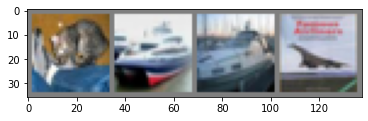

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
vgg16 = vgg16.to(device)
outputs = vgg16(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship plane


우선 몇가지 case에 대해서 적용한 결과는 4개 중 3개를 맞췄습니다.  
모든 test data에 대해서 적용해보도록 하겠습니다.

In [14]:
correct = 0
total = 0

from tqdm import tqdm

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 275.59it/s]

Accuracy of the network on the 10000 test images: 77 %


이 모델도 간단한 모델이라 성능이 썩 좋지만은 않은 것 같습니다.  
하지만 우리의 목적은 accuracy보다 explanation에 있기 때문에 우선은 넘어가도록 하겠습니다.

## B. Class Activation Map

본격적으로 모델에 대한 explanation을 제시해보도록 하겠습니다.  
활용할 방법은 GAP의 weight를 활용하여 의사결정에 모델이 중점적으로 본 부분을 Heat-Map으로 파악하는 것입니다.  
중요도를 계산하여, 그것을 히트맵으로 놓고 input image에 씌우도록 하겠습니다.  
HeatMap을 그리는 코드는 
- 논문의 깃헙인 https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
- Keras의 CAM 관련 코드인 https://keras.io/examples/vision/grad_cam/  
을 참고하였습니다.

In [20]:
import cv2
from tensorflow import keras
import matplotlib.cm as cm

Explanation을 제시할 사진은 아래와 같습니다.  
비행기의 어디를 보고 비행기라고 파악하였는지 확인해보겠습니다.  
이미지 출처는 아래와 같습니다.  
https://www.diesel-plus.com/10-steps-on-how-to-fly-a-plane/

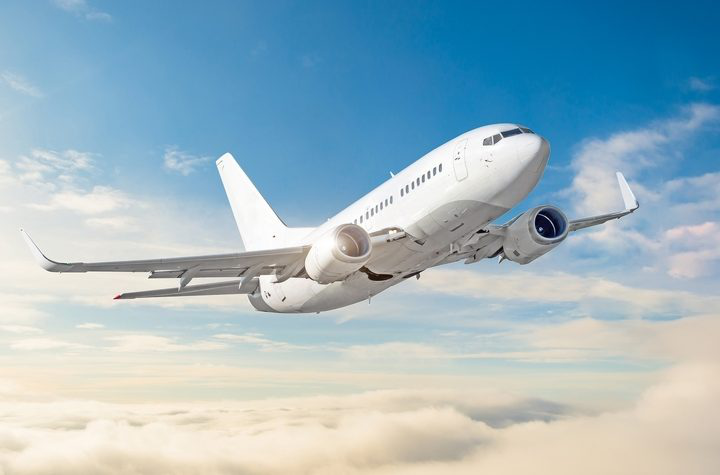

In [18]:
img = keras.preprocessing.image.load_img("airplane.jpg")
img

In [21]:
def class_activation_map(img_path, model, adj_term) : 
    
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    sq_n = np.min(img.shape[:2])
    
    # Scaling
    normalizer =  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    crop =  transforms.CenterCrop((sq_n, sq_n))
    pytorch_img = np.transpose(img, (2, 0, 1))
    new_img = normalizer(torch.tensor(pytorch_img/255))
    new_img = crop(new_img)
    
    # Passing Model
    outs = model(new_img.reshape(1, 3, sq_n, sq_n).to(device))
    out_y = torch.argmax(outs)
    print("Predicted Class is {0}".format(classes[torch.argmax(outs)]))
    
    # Getting f value
    heats_n = model.activation_value.shape[2]
    new_heat = model.activation_value.view(512, heats_n, heats_n) * model.last_classes.weight[out_y].reshape(512, 1, 1)
    out_heat = torch.sum(new_heat, 0)
    final_heats = cv2.resize(out_heat.to("cpu").detach().numpy(), (sq_n,sq_n))
    
    # Generating heatmap
    jet = cm.get_cmap("jet")
    x_transformed = jet(final_heats/adj_term)
    
    # Mixing up
    c1 = keras.preprocessing.image.array_to_img((x_transformed[:, :, :3]*0.8) + np.transpose(new_img.numpy(), (1,2,0)))
    
    # Printing outcome
    plt.figure(figsize = (10, 5))
    plt.subplot(121)
    plt.imshow(img/255)
    plt.subplot(122)
    #plt.show()
    plt.imshow(c1)
    plt.show()

Predicted Class is plane


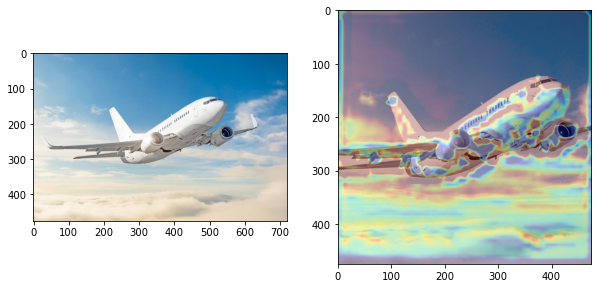

In [22]:
class_activation_map("airplane.jpg", vgg16, 30)

실험 결과   
**a. 전반적인 비행기체 부분**  
**b. 푸른 하늘**  
을 보고 비행기라고 예측하였습니다.   
특히, 푸른 하늘을 보고 비행기라고 예측한 것은 모델이 일종의 편법을 사용해서  
비행기를 맞춘 것으로 보입니다.  
CAM을 통해서, 모델이 어느 부분을 보고 decision을 내리는지 대략적인 파악이 가능합니다.